In [1]:
import datetime as dt
import glob

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy import stats
from sklearn import metrics, preprocessing
from sklearn.metrics import (accuracy_score, classification_report,
                             confusion_matrix)
from sklearn.model_selection import (GridSearchCV, RandomizedSearchCV,
                                     StratifiedKFold, cross_val_score,
                                     train_test_split)
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn import model_selection

# 8.1

## 8.1a Load and prepare data

In [2]:
ACC   = pd.read_csv('acceleration.txt', sep = ' ',names=['timedelta', 'accX', 'accY', 'accZ'])
HeartR = pd.read_csv('heartrate.txt', sep = ',',names=['timedelta', 'heartrate'])
SleepL = pd.read_csv('labeled_sleep.txt', sep = ' ',names=['timedelta', 'sleep'])

In [3]:
# Check 'timedelta' max(), min() of ACC, HeartR, SleepL (ช่วงเวลาที่มีข้อมูลใกล้กัน)
ACC_max_date = ACC['timedelta'].max()
ACC_min_date = ACC['timedelta'].min()
# หา start_timedelta, end_timedelta
HeartR_max = HeartR['timedelta'].max()
HeartR_min = HeartR['timedelta'].min()

SleepL_max = SleepL['timedelta'].max()
SleepL_min = SleepL['timedelta'].min()

print(f'ACC start: {ACC_min_date} ACC end: {ACC_max_date}')
print(f'HeartR start: {HeartR_min} HeartR end: {HeartR_max}')
print(f'SleepL start: {SleepL_min} SLeepL end: {SleepL_max}')


ACC start: -124489.16105 ACC end: 17643.046417
HeartR start: -556410.36066 HeartR end: 16980.47229
SleepL start: 0 SLeepL end: 16980


In [4]:
 # select only intersected timedelta (ACC, HeartR, SleepL) (ช่วงเวลาที่มีข้อมูลใกล้กัน) #เลือกขอบ
ACC_new = ACC[(ACC['timedelta'] > SleepL_min) & (ACC['timedelta'] < SleepL_max)]
HeartR_new = HeartR[(HeartR['timedelta']> SleepL_min) & HeartR['timedelta']< SleepL_max]
SleepL_new = SleepL[(SleepL['timedelta']> SleepL_min) & SleepL['timedelta']< SleepL_max]

## 8.1b Load and prepare data acc ปรับ sampling ข้อมูลเป็น 1 sec

In [5]:
 # Convert to datetime and round to second,
 # ------------ Rounding ACC (Rounding to 1 sec) -------------------------------
ACC_new['timedelta'] = pd.DataFrame(pd.to_timedelta(ACC_new['timedelta'], unit='s').round('1s'))
ACC_new

C:\Users\ADMIN\AppData\Local\Temp\ipykernel_18776\2630731856.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ACC_new['timedelta'] = pd.DataFrame(pd.to_timedelta(ACC_new['timedelta'], unit='s').round('1s'))


,timedelta,accX,accY,accZ
98777,0 days 00:00:00,-0.234650,0.905975,0.362747
98778,0 days 00:00:00,-0.231232,0.893265,0.371613
98779,0 days 00:00:00,-0.227814,0.915848,0.369049
98780,0 days 00:00:00,-0.240524,0.919159,0.352890
98781,0 days 00:00:00,-0.240448,0.889175,0.350143
...,...,...,...,...
948796,0 days 04:43:00,-0.442413,-0.527573,0.723450
948797,0 days 04:43:00,-0.441925,-0.527573,0.721985
948798,0 days 04:43:00,-0.441437,-0.526108,0.721985
948799,0 days 04:43:00,-0.443405,-0.525116,0.723434


In [6]:
# Average rounding duplicated time
df_acc_X = ACC_new.groupby('timedelta')['accX'].mean().reset_index()
df_acc_Y = ACC_new.groupby('timedelta')['accY'].mean().reset_index()
df_acc_Z = ACC_new.groupby('timedelta')['accZ'].mean().reset_index()
ACC = pd.concat([df_acc_X, df_acc_Y, df_acc_Z], axis=1)
ACC = ACC.loc[:,~ACC.columns.duplicated()].copy() #ตัด duplicate columns(timedelta)
ACC

,timedelta,accX,accY,accZ
0,0 days 00:00:00,-0.243203,0.895372,0.367591
1,0 days 00:00:01,-0.240757,0.873826,0.415446
2,0 days 00:00:02,-0.244620,0.883943,0.387026
3,0 days 00:00:03,-0.248036,0.902427,0.347812
4,0 days 00:00:04,-0.241778,0.912946,0.321502
...,...,...,...,...
16976,0 days 04:42:56,-0.442763,-0.525892,0.722950
16977,0 days 04:42:57,-0.441990,-0.525476,0.723410
16978,0 days 04:42:58,-0.441581,-0.525116,0.724003
16979,0 days 04:42:59,-0.442283,-0.525849,0.723265


## 8.1c Load and prepare data heart rate

In [7]:
# ------------ Rounding Heart Rate (Rounding to 1 sec) -------------------------------
HeartR_new['timedelta'] = pd.DataFrame(pd.to_timedelta(HeartR_new['timedelta'],unit='s').round('1s'))

In [8]:
# Resampling every 1s with median with ffill
resample_rule = '1s'
HeartR_new2 = HeartR_new.set_index('timedelta').resample(resample_rule,).median().ffill()

## 8.1d load and prepare data sleep label

In [9]:
# ------------ Rounding Sleep Label (Rounding to 1 sec) -------------------------------
SleepL_new['timedelta'] = pd.DataFrame(pd.to_timedelta(SleepL_new['timedelta'],unit='s').round('1s'))

In [10]:
# Resampling every 1s with median with ffill
resample_rule = '1s'
SleepL_new2 = SleepL_new.set_index('timedelta').resample(resample_rule,).median().ffill()

## 8.1e Merge data andd standardized data

In [11]:
# ------------Merge All Data -------------------------------
df = []
df = pd.merge_asof(ACC, HeartR_new2, on='timedelta')
df = pd.merge_asof(df, SleepL_new2, on = 'timedelta')


In [12]:
# Fill NA
# Heart rate
# Fillna() # using median()
heart_mean = df.heartrate.mean()
df.heartrate.fillna(heart_mean,inplace=True)
# # Sleep Label
# Fillna() # with 0
df.sleep.fillna(0,inplace=True)
# # Drop column
df.drop(columns='timedelta',inplace=True)
df

,accX,accY,accZ,heartrate,sleep
0,-0.243203,0.895372,0.367591,87.0,-1.0
1,-0.240757,0.873826,0.415446,87.0,-1.0
2,-0.244620,0.883943,0.387026,87.0,-1.0
3,-0.248036,0.902427,0.347812,87.0,-1.0
4,-0.241778,0.912946,0.321502,87.0,-1.0
...,...,...,...,...,...
16976,-0.442763,-0.525892,0.722950,76.0,0.0
16977,-0.441990,-0.525476,0.723410,76.0,0.0
16978,-0.441581,-0.525116,0.724003,76.0,0.0
16979,-0.442283,-0.525849,0.723265,76.0,0.0


In [13]:
# Standardized data
feature_columns = ['accX', 'accY', 'accZ', 'heartrate']
label_columns = ['sleep']
standard_scaler = preprocessing.StandardScaler()
df[feature_columns] = standard_scaler.fit_transform(df[feature_columns])

df_feature = df[feature_columns]
df_label = df[label_columns]
df_feature

,accX,accY,accZ,heartrate
0,-0.587547,3.058075,0.698728,0.788122
1,-0.581456,2.995094,0.757746,0.788122
2,-0.591075,3.024668,0.722696,0.788122
3,-0.599581,3.078699,0.674335,0.788122
4,-0.583998,3.109450,0.641889,0.788122
...,...,...,...,...
16976,-1.084456,-1.096565,1.136974,-0.630659
16977,-1.082531,-1.095348,1.137542,-0.630659
16978,-1.081511,-1.094296,1.138273,-0.630659
16979,-1.083260,-1.096440,1.137363,-0.630659


### Visualize signals

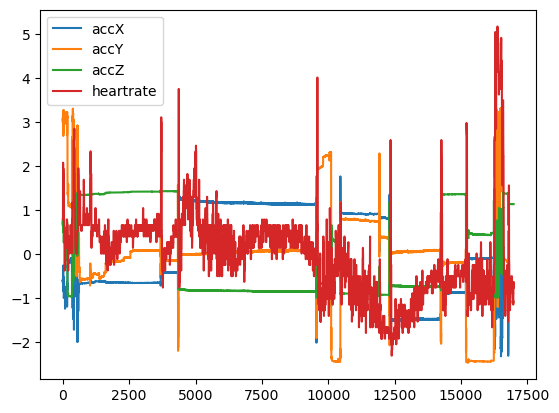

In [14]:
lst = [int(i) for i in range(len(df[feature_columns]))]
plt.plot(lst,df_feature.accX,label ="accX")
plt.plot(lst,df_feature.accY,label ="accY")
plt.plot(lst,df_feature.accZ,label ="accZ")
plt.plot(lst,df_feature.heartrate,label ="heartrate")
plt.legend()

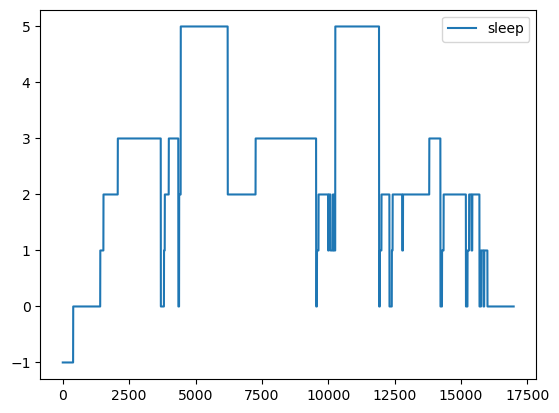

In [15]:
lst = [int(i) for i in range(len(df.heartrate))]
plt.plot(lst,df_label.sleep ,label = 'sleep')
plt.legend()

# 8.2

## 8.2 a svm model training and testing

In [16]:
x = df_feature
y = df_label
seed = 55
x_train,x_test, y_train, y_test = model_selection.train_test_split(x, y, test_size=0.3, random_state=seed)

In [17]:
# Model Traing Parameter
# Create SVC model
c_val = 100 
gmm =0.1
d = 2

In [18]:
# Model initialize
svc_lin = SVC(kernel='linear', C=c_val)
svc_rbf = SVC(kernel='rbf', C=c_val, gamma=gmm)
svc_poly = SVC(kernel='poly', C=c_val, degree = d)

In [19]:
# Model Training
svc_lin = svc_lin.fit(x_train,y_train)
svc_rbf = svc_rbf.fit(x_train, y_train)
svc_poly = svc_poly.fit(x_train, y_train)

c:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [20]:
# Model Testing (Predict)
svc_lin_pred = svc_lin.predict(x_test)
svc_rbf_pred = svc_rbf.predict(x_test)
svc_poly_pred = svc_poly.predict(x_test)

## 8.2b svm prediction report

In [21]:
print('----- Confusion matrix of SVC linear -----')
print(confusion_matrix(y_test,svc_lin_pred))
print('----- Confusion matrix of SVC Rbf -----')
print(confusion_matrix(y_test,svc_rbf_pred))
print('----- Confusion matrix of SVC Poly -----')
print(confusion_matrix(y_test,svc_poly_pred))

----- Confusion matrix of SVC linear -----
[[  91    0    0    7    0    0]
 [  43  415    0  173   62   22]
 [  11   91    0  117   41   17]
 [  20   81    0  920   75  432]
 [   0    2    0   61  627  696]
 [   0   59    0    0    0 1032]]
----- Confusion matrix of SVC Rbf -----
[[  98    0    0    0    0    0]
 [   2  540    8  137   21    7]
 [   0   69   60  131    4   13]
 [   0   40    9 1383   73   23]
 [   0    0    0   50 1336    0]
 [   7    1    1  181    0  901]]
----- Confusion matrix of SVC Poly -----
[[  96    2    0    0    0    0]
 [   6  507  109   64   21    8]
 [   3   19  114  115   12   14]
 [   2   31  115 1150  174   56]
 [   0   18    0  132 1236    0]
 [   0    0    3  152    6  930]]


In [22]:
print('----- Classification matrix of SVC linear -----')
print(classification_report(y_test,svc_lin_pred))
print('----- Classification matrix of SVC Rbf -----')
print(classification_report(y_test,svc_rbf_pred))
print('----- Classification matrix of SVC Poly -----')
print(classification_report(y_test,svc_poly_pred))

----- Classification matrix of SVC linear -----
              precision    recall  f1-score   support

        -1.0       0.55      0.93      0.69        98
         0.0       0.64      0.58      0.61       715
         1.0       0.00      0.00      0.00       277
         2.0       0.72      0.60      0.66      1528
         3.0       0.78      0.45      0.57      1386
         5.0       0.47      0.95      0.63      1091

    accuracy                           0.61      5095
   macro avg       0.53      0.58      0.53      5095
weighted avg       0.63      0.61      0.59      5095

----- Classification matrix of SVC Rbf -----
              precision    recall  f1-score   support

        -1.0       0.92      1.00      0.96        98
         0.0       0.83      0.76      0.79       715
         1.0       0.77      0.22      0.34       277
         2.0       0.73      0.91      0.81      1528
         3.0       0.93      0.96      0.95      1386
         5.0       0.95      0.83      

c:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


# 8.3 Hyperparameter Tuning

In [23]:
#Create Model Parameter Dictionary for SVC
kernel = ['rbf','poly']
C_list = [0.1, 1.0, 10.0 ] #100.0, 200.0, 500.0
Gamma_list = [0.01, 0.1, 1.0, 10]
d_list = [2] # ,3
params = dict(kernel = kernel,C = C_list,gamma = Gamma_list,degree = d_list)

In [24]:
# Perform GridsearchCV() for each classification model
grid = GridSearchCV(estimator = SVC(), n_jobs=8,verbose = 10, scoring = 'accuracy', cv = 2, param_grid= params)
grid_result = grid.fit(x_train, y_train)

Fitting 2 folds for each of 24 candidates, totalling 48 fits


c:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [25]:
# Show best search results
print('Best params: ',grid_result.best_params_)
print('Best score: ', grid_result.best_score_)

Best params:  {'C': 10.0, 'degree': 2, 'gamma': 10, 'kernel': 'rbf'}
Best score:  0.897778899545684


In [26]:
# Show and Display Mean, std, params
means   = grid_result.cv_results_['mean_test_score']
stds    = grid_result.cv_results_['std_test_score']
params  = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

0.501767 (0.008245) with: {'C': 0.1, 'degree': 2, 'gamma': 0.01, 'kernel': 'rbf'}
0.300690 (0.000168) with: {'C': 0.1, 'degree': 2, 'gamma': 0.01, 'kernel': 'poly'}
0.639744 (0.001851) with: {'C': 0.1, 'degree': 2, 'gamma': 0.1, 'kernel': 'rbf'}
0.485193 (0.002103) with: {'C': 0.1, 'degree': 2, 'gamma': 0.1, 'kernel': 'poly'}
0.727074 (0.000673) with: {'C': 0.1, 'degree': 2, 'gamma': 1.0, 'kernel': 'rbf'}
0.689467 (0.002608) with: {'C': 0.1, 'degree': 2, 'gamma': 1.0, 'kernel': 'poly'}
0.774525 (0.001346) with: {'C': 0.1, 'degree': 2, 'gamma': 10, 'kernel': 'rbf'}
0.778058 (0.001346) with: {'C': 0.1, 'degree': 2, 'gamma': 10, 'kernel': 'poly'}
0.555275 (0.013125) with: {'C': 1.0, 'degree': 2, 'gamma': 0.01, 'kernel': 'rbf'}
0.391890 (0.017668) with: {'C': 1.0, 'degree': 2, 'gamma': 0.01, 'kernel': 'poly'}
0.722447 (0.003786) with: {'C': 1.0, 'degree': 2, 'gamma': 0.1, 'kernel': 'rbf'}
0.654552 (0.001514) with: {'C': 1.0, 'degree': 2, 'gamma': 0.1, 'kernel': 'poly'}
0.790089 (0.001262) 

In [27]:
score_df = pd.DataFrame(grid_result.cv_results_)
rbf_result = score_df[score_df['param_kernel'] == 'rbf']
rbf_param = [str(i) for i in rbf_result.params]
poly_result = score_df[score_df['param_kernel'] == 'poly']
poly_param = [str(i) for i in poly_result.params]

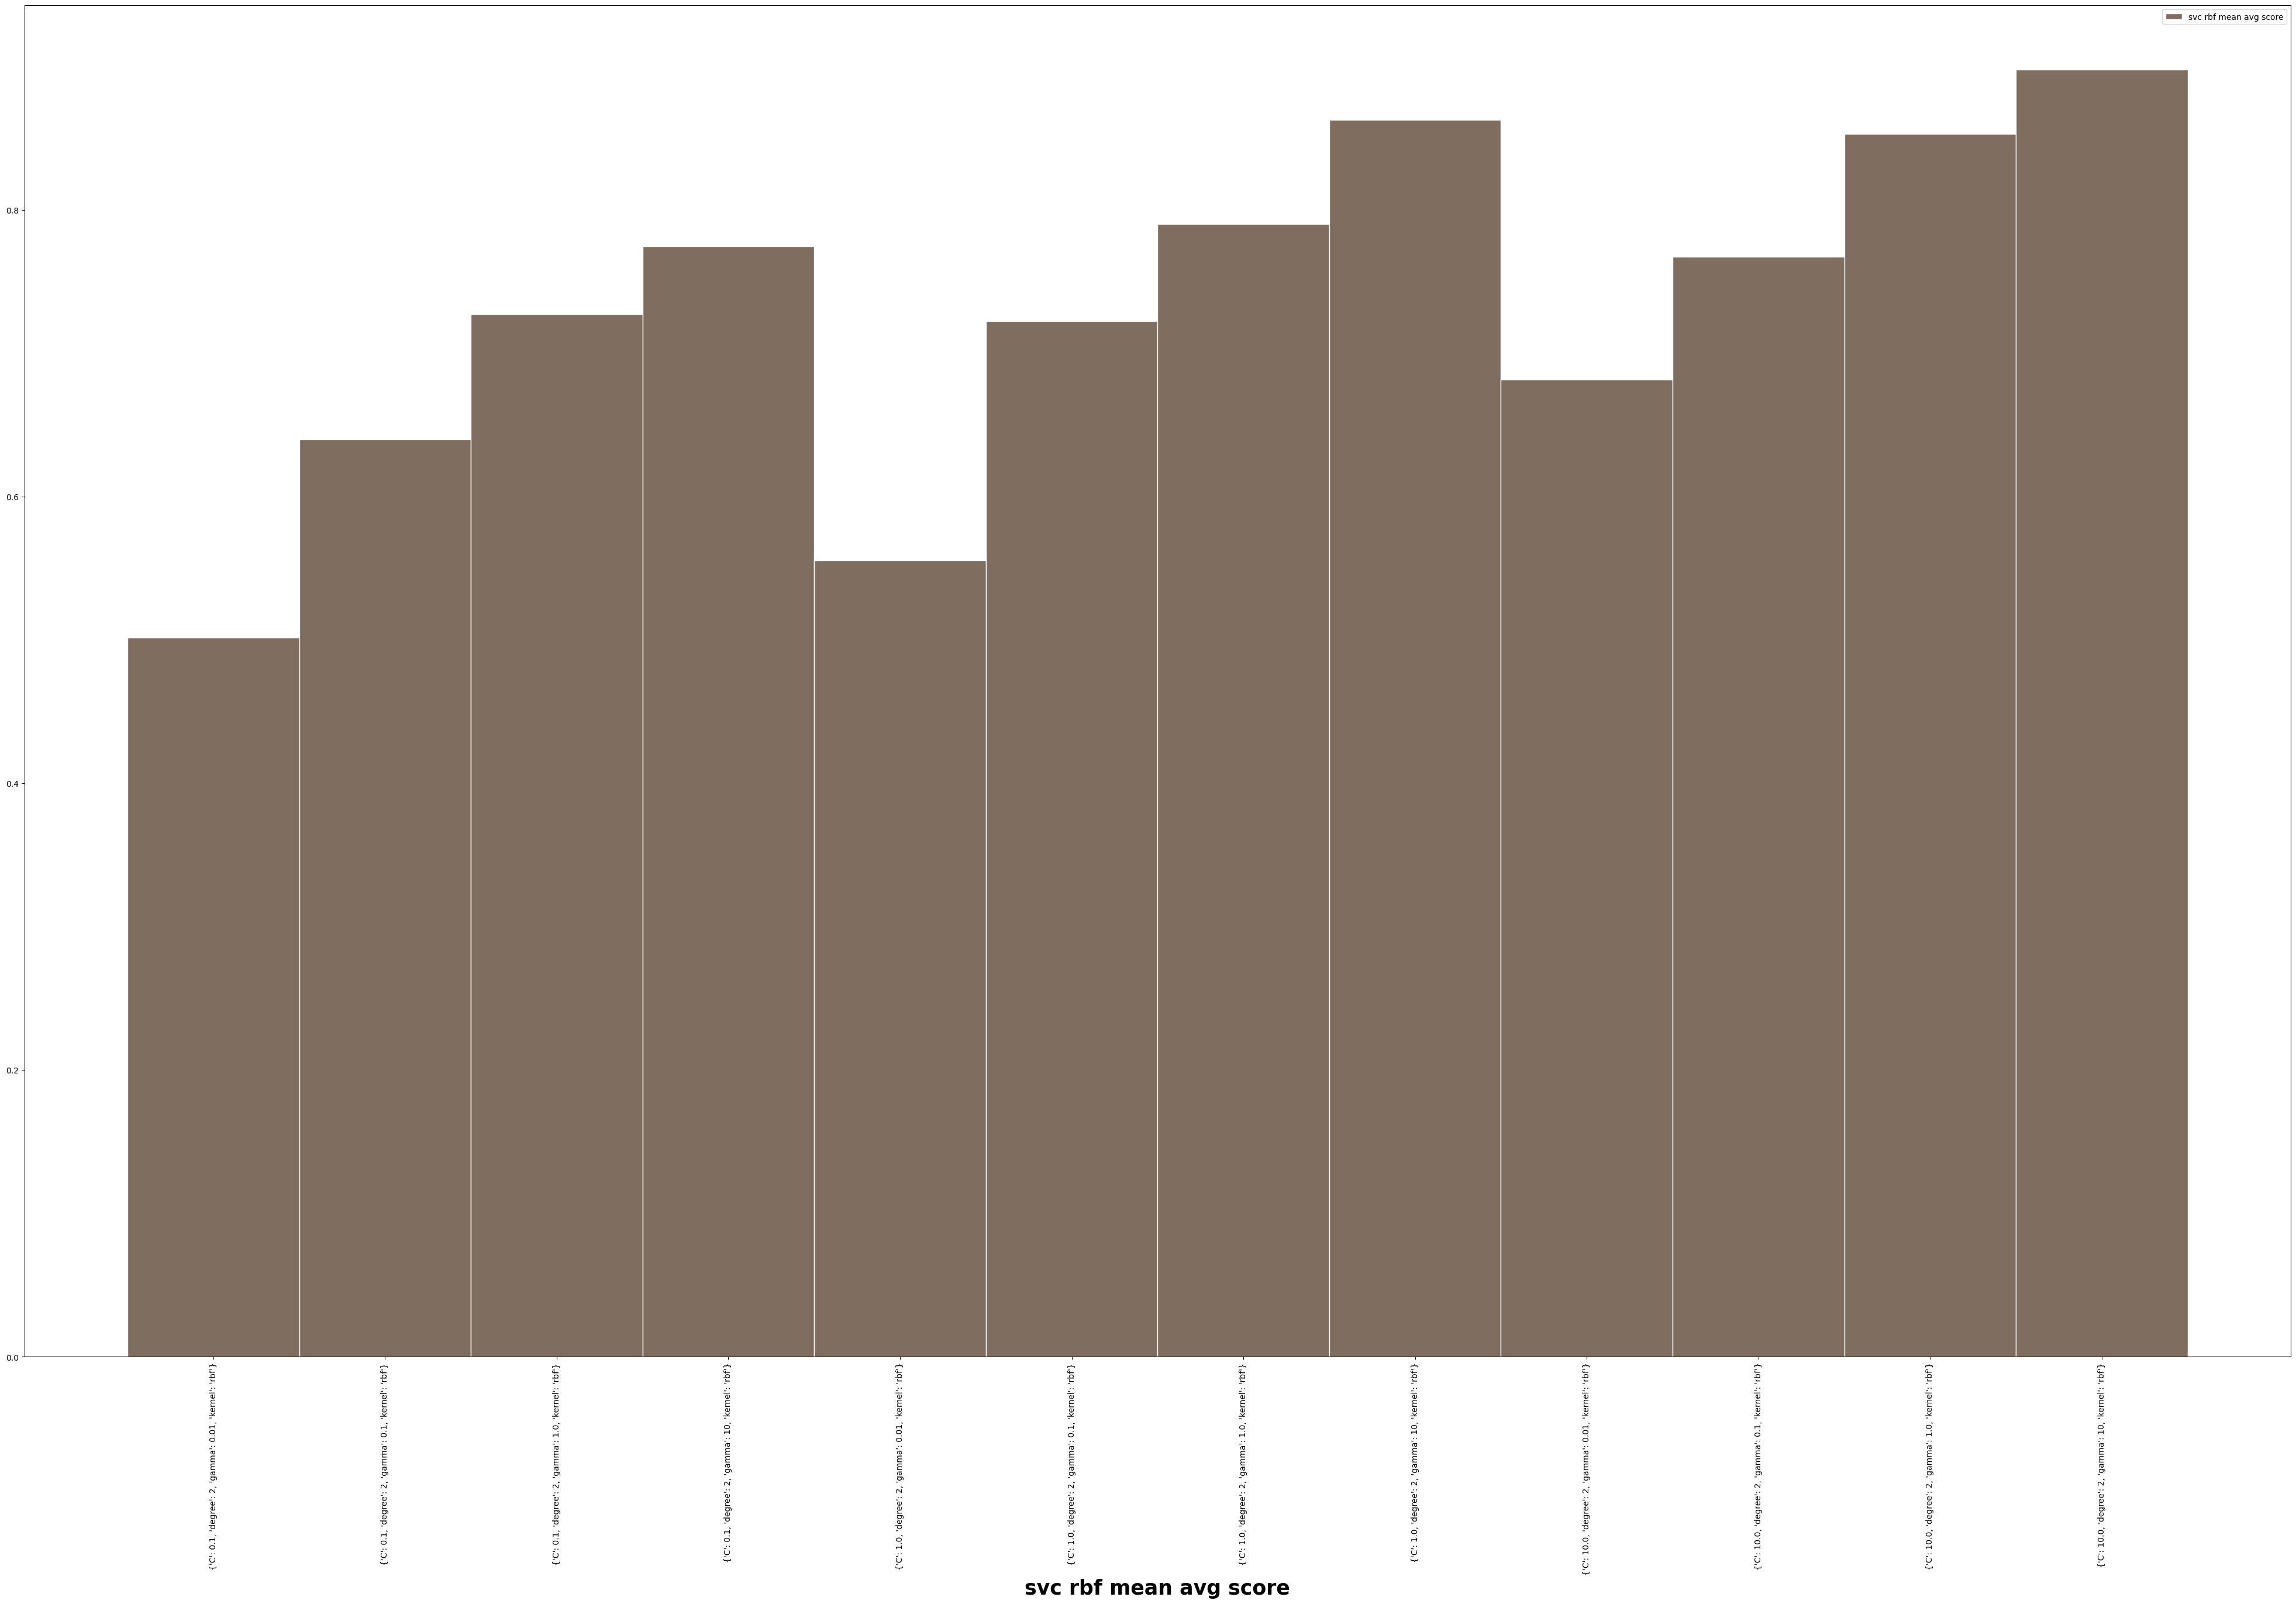

In [31]:
# set width of bars
barWidth = 1
plt.figure(figsize=(50,30))
# Make the plot
plt.bar(rbf_param, rbf_result.mean_test_score, color='#7f6d5f', width=barWidth, edgecolor='white', label='svc rbf mean avg score') 
# Add xticks on the middle of the group bars
plt.xlabel('svc rbf mean avg score', fontweight='bold',fontsize=25)
plt.xticks(rotation=90)
# Create legend & Show graphic
plt.legend()
plt.show()

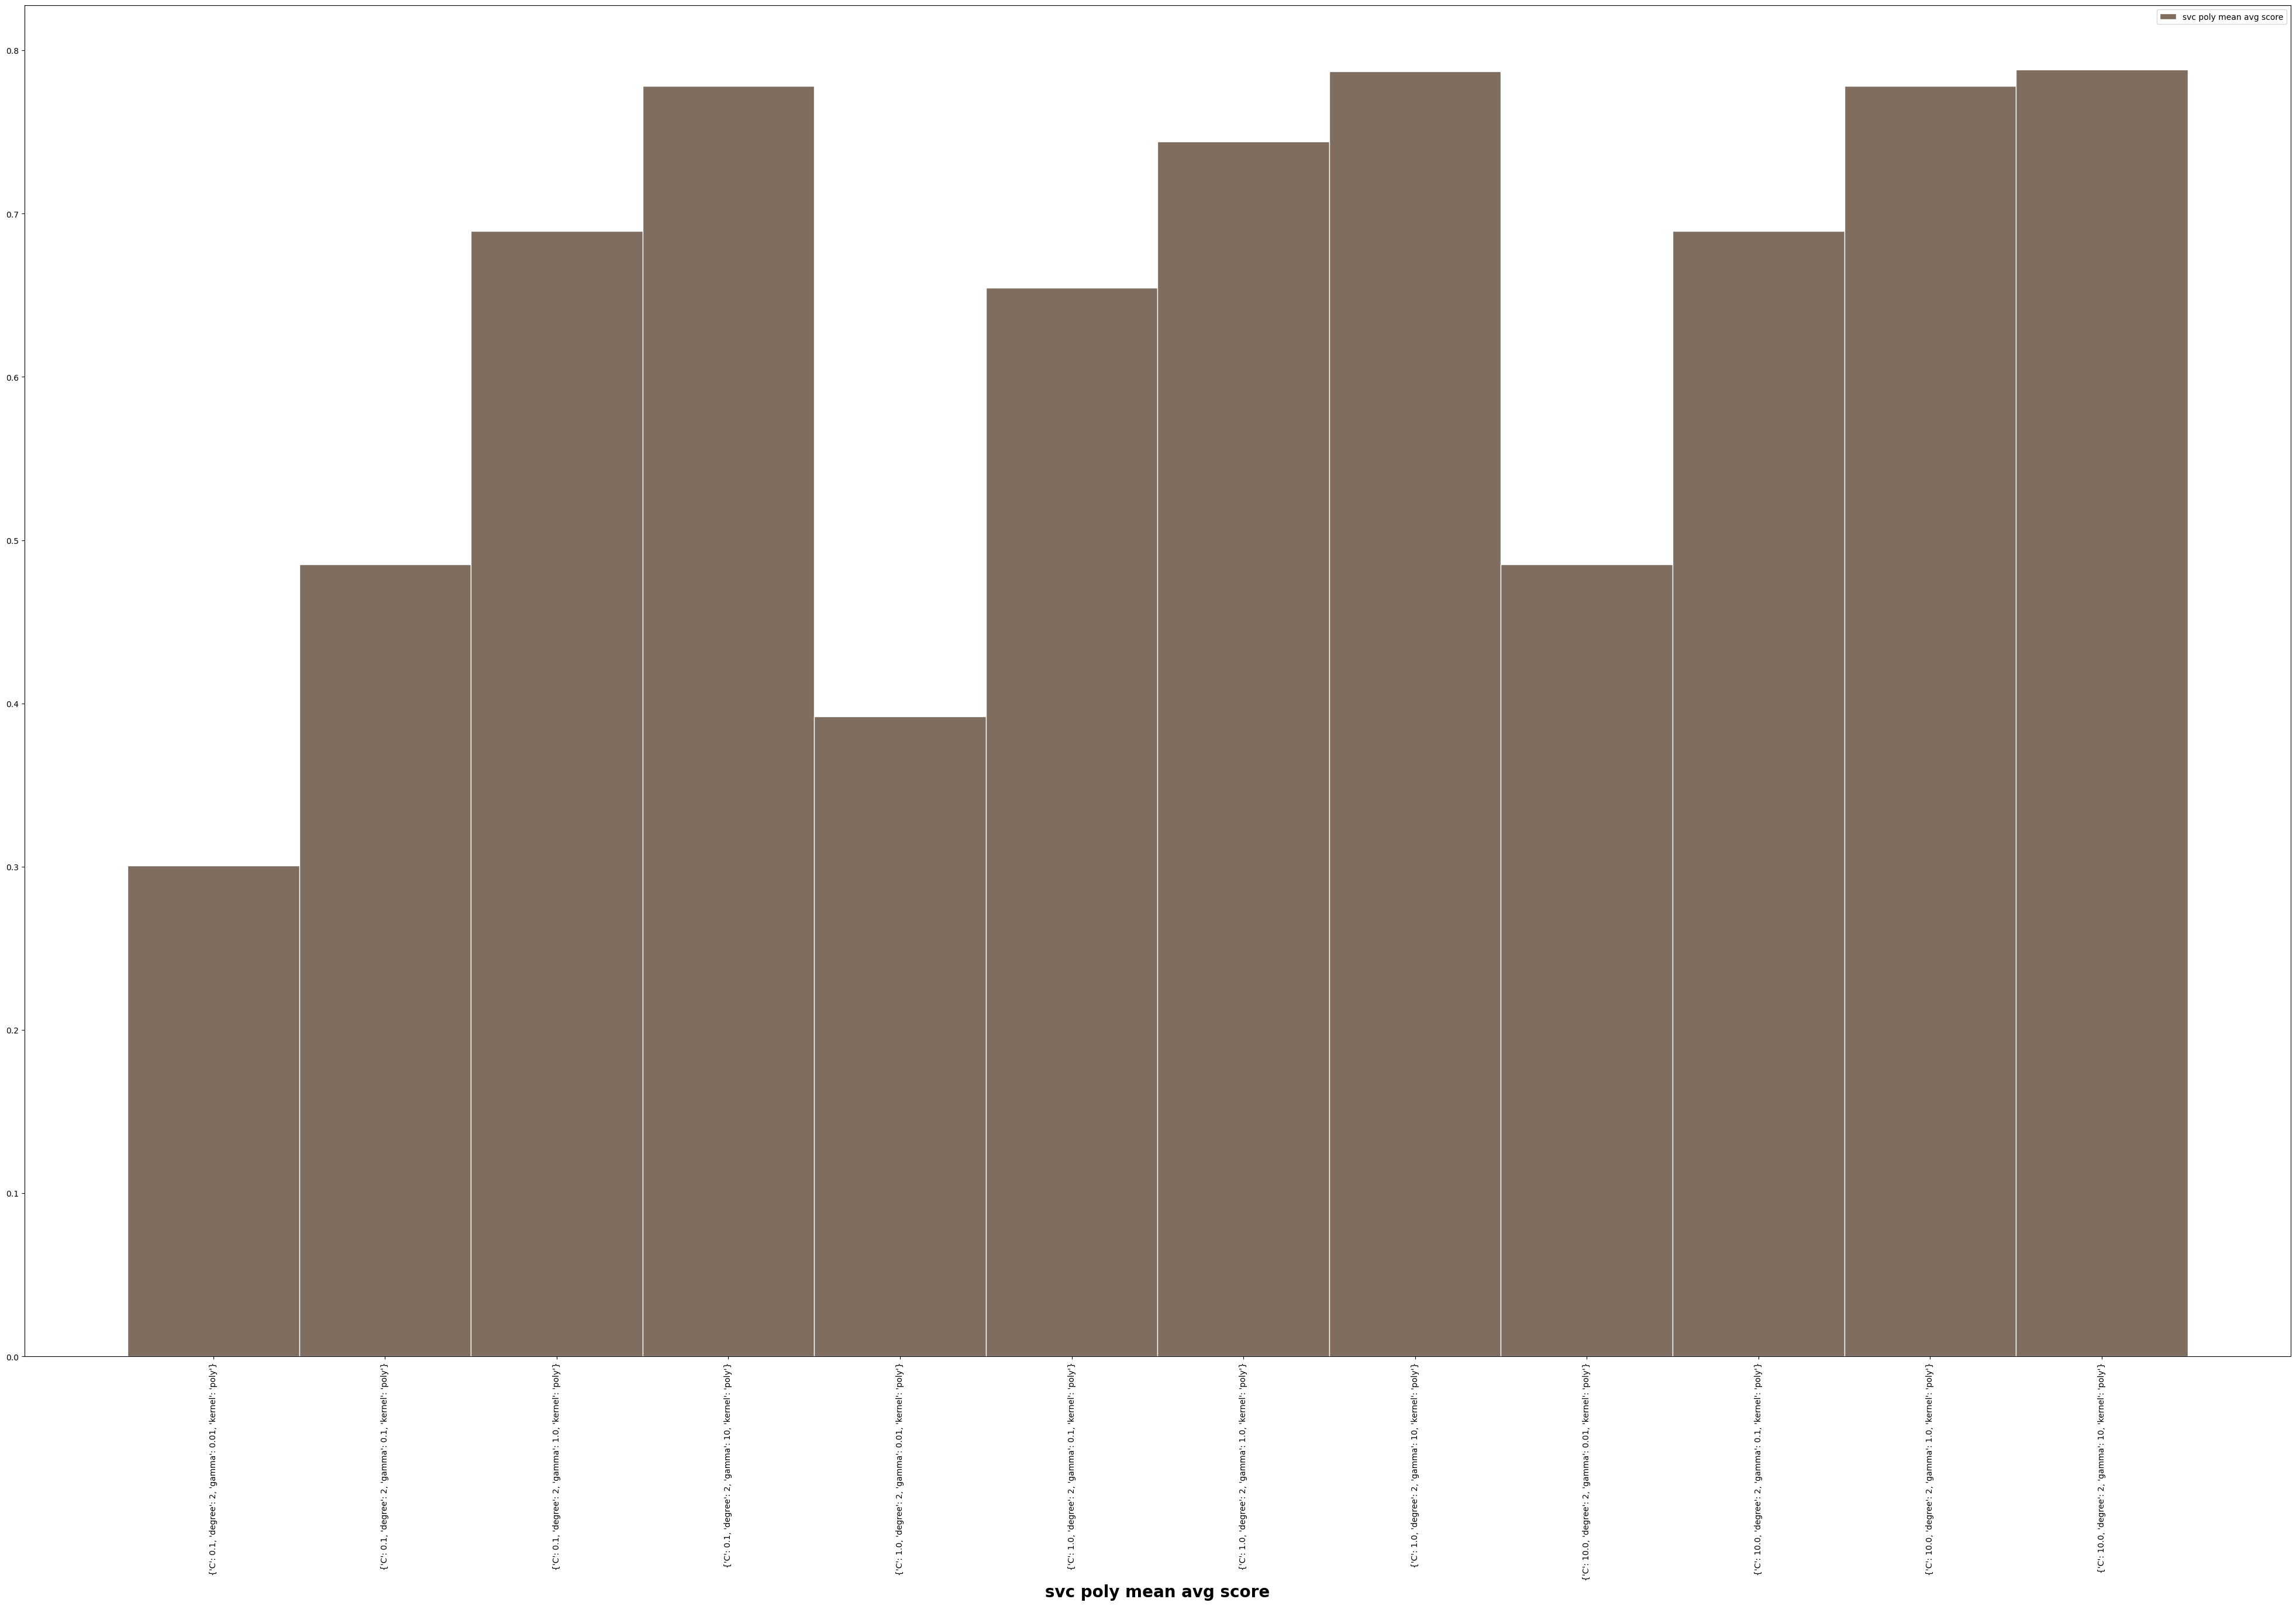

In [30]:
# set width of bars
barWidth = 1 
plt.figure(figsize=(50,30))
# Make the plot
plt.bar(poly_param, poly_result.mean_test_score, color='#7f6d5f', width=barWidth, edgecolor='white', label='svc poly mean avg score') 
# Add xticks on the middle of the group bars
plt.xlabel('svc poly mean avg score', fontweight='bold',fontsize=20)
plt.xticks(rotation=90)
# Create legend & Show graphic
plt.legend()
plt.show()